# Detecting New Particles in HEPMASS Dataset

## Introduction

### Machine Learning in High Energy Physics
Machine learning is a powerful tool for finding patterns in large datasets. In this project, I will apply ML tools and principles to sift through data generated by simulations of particle collisions, searching for signatures of new particles. The dataset comes from Monte Carlo simulations, which mimic the physical processes in a particle detector. 

We aim to classify each collision event as either:
1. **Signal:** A collision that might indicate the production of a new particle.
2. **Background:** A collision with no new particles, meaning it aligns with the Standard Model's prediction.

### Dataset
The HEPMASS dataset provides three different scenarios:
1. **1000 Dataset:** The signal particle always has a mass of 1000 (a fixed value), and its mass is not included as a feature in the dataset.
2. **not1000 Dataset:** The signal particle’s mass is randomly chosen from {500, 750, 1250, 1500}, and the mass is included as a feature.
3. **all Dataset:** The signal particle’s mass is randomly chosen from {500, 750, 1000, 1250, 1500}, and the mass is included as a feature.

### Objectives
Through this project, we aim to:
- Use machine learning to classify particle collisions as signal or background.
- Understand how the inclusion of certain features, like mass, affects the model's performance.
- Provide insights into how ML can assist physicists in making new discoveries.

### Significance for Non-Physicists
Although this project is rooted in high-energy physics, it showcases the power of machine learning to solve real-world problems involving large, complex datasets, such as detecting fraud and predicting diseases from medical data. The methods used here are widely applicable across industries and real-world cases.

### Citation
Whiteson, Daniel. "HEPMASS." UCI Machine Learning Repository, 2016, https://doi.org/10.24432/C5PP5W.

In [13]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, auc

In [14]:
# Load training datasets
all_data_train = pd.read_csv('/Users/peterzheng/Downloads/hepmass/all_train.csv.gz', compression='gzip')
not1000_data_train = pd.read_csv('/Users/peterzheng/Downloads/hepmass/not1000_train.csv.gz', compression='gzip')
dataset_1000_train = pd.read_csv('/Users/peterzheng/Downloads/hepmass/1000_train.csv.gz', compression='gzip')

In [15]:
print(dataset_1000_train.head())
print(dataset_1000_train.info())
print(dataset_1000_train.describe())

      # label        f0        f1        f2        f3        f4        f5  \
1.0  0.217896  0.933072 -0.596174  1.148478 -1.054270  0.850488  1.660115   
1.0  1.569236  1.686193 -0.222665  0.485782 -0.544683 -1.054221  0.059797   
0.0 -0.360693  1.794174  0.264738 -0.472273 -0.292344 -1.054221 -1.150495   
1.0 -0.691130 -1.063802 -1.198263  0.691331 -1.083016 -1.054221  0.769120   
0.0 -0.067436 -0.636762 -0.620166 -0.062551  1.588715 -0.005984 -0.595304   

           f6        f7        f8  ...       f16       f17       f18  \
1.0 -1.315179  0.645059 -1.325801  ...  1.226331  2.104148 -1.281571   
1.0 -0.015302  1.363171  0.754261  ...  1.226331 -0.371889  0.092913   
0.0  1.423404  1.270098  0.754261  ...  1.226331 -1.199511  0.539020   
1.0 -0.280765 -1.228812 -1.325801  ...  1.226331 -0.719277  0.741245   
0.0 -1.238987  0.336844 -1.325801  ... -0.815440 -0.552837 -1.418494   

          f19       f20       f21       f22       f23       f24       f25  
1.0 -0.379576 -0.573682  1.5

## Data Preprocessing

In [17]:
columns = ['# label'] + [f'f{i}' for i in range(27)]  

dtypes = {col: 'float64' for col in columns}  
dtypes['# label'] = 'float64'  


dataset_1000_train = pd.read_csv(
    '/Users/peterzheng/Downloads/hepmass/1000_train.csv.gz',  
    compression='gzip',
    header=0,  
    names=columns,  
    dtype=dtypes,  
    on_bad_lines='skip',  
    low_memory=False,  
)

dataset_1000_train = dataset_1000_train[dataset_1000_train['# label'].isin([0, 1])]

print(dataset_1000_train.head())
print(f"Number of rows: {len(dataset_1000_train)}")
print(f"Number of columns: {len(dataset_1000_train.columns)}")

   # label        f0        f1        f2        f3        f4        f5  \
0      1.0  0.217896  0.933072 -0.596174  1.148478 -1.054270  0.850488   
1      1.0  1.569236  1.686193 -0.222665  0.485782 -0.544683 -1.054221   
2      0.0 -0.360693  1.794174  0.264738 -0.472273 -0.292344 -1.054221   
3      1.0 -0.691130 -1.063802 -1.198263  0.691331 -1.083016 -1.054221   
4      0.0 -0.067436 -0.636762 -0.620166 -0.062551  1.588715 -0.005984   

         f6        f7        f8  ...       f17       f18       f19       f20  \
0  1.660115 -1.315179  0.645059  ...  1.226331  2.104148 -1.281571 -0.379576   
1  0.059797 -0.015302  1.363171  ...  1.226331 -0.371889  0.092913  0.817892   
2 -1.150495  1.423404  1.270098  ...  1.226331 -1.199511  0.539020 -1.590629   
3  0.769120 -0.280765 -1.228812  ...  1.226331 -0.719277  0.741245  0.480195   
4 -0.595304 -1.238987  0.336844  ... -0.815440 -0.552837 -1.418494 -0.562982   

        f21       f22       f23       f24       f25       f26  
0 -0.57368

### EDA

In [18]:
# Check class distribution
datasets = {"all": all_data_train, "not1000": not1000_data_train, "1000": dataset_1000_train}
for name, data in datasets.items():
    print(f"{name.capitalize()} Dataset Class Distribution:")
    print(data['# label'].value_counts(normalize=True))
    print()

All Dataset Class Distribution:
1.0    0.500126
0.0    0.499874
Name: # label, dtype: float64

Not1000 Dataset Class Distribution:
1.0    0.500126
0.0    0.499874
Name: # label, dtype: float64

1000 Dataset Class Distribution:
1.0    0.500126
0.0    0.499874
Name: # label, dtype: float64



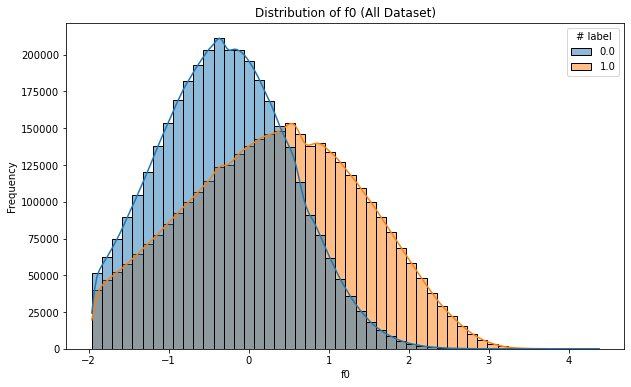

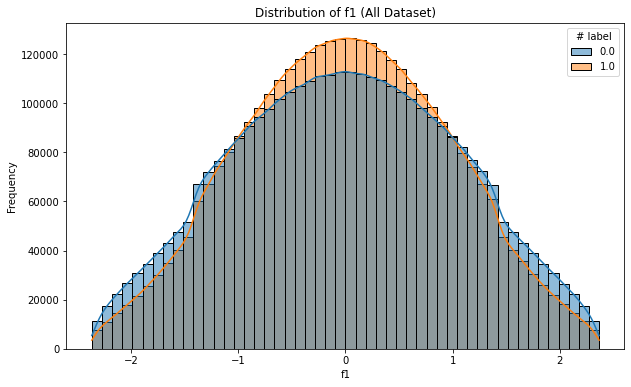

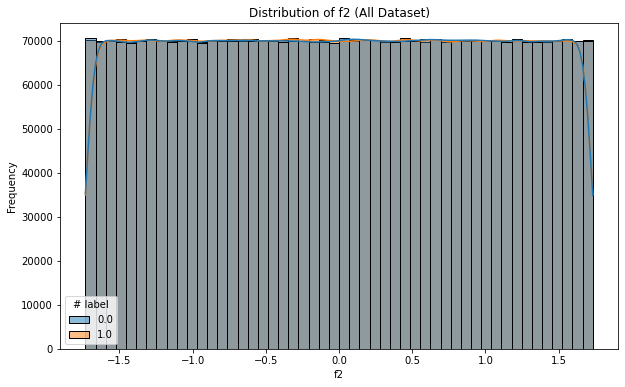

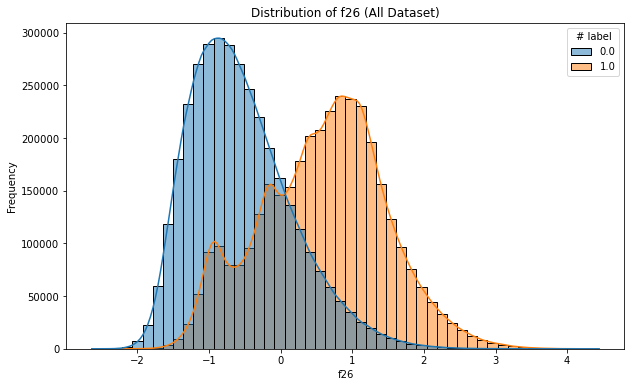

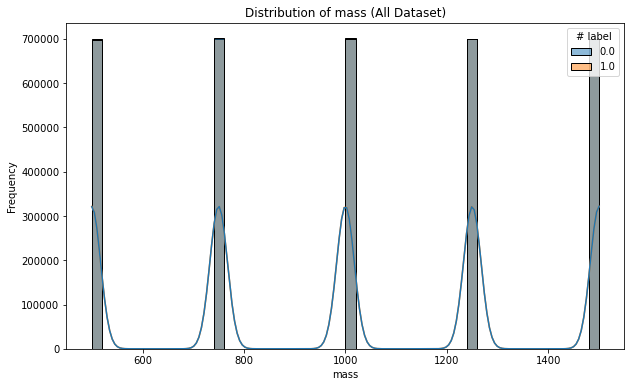

In [19]:
# Plot histograms for a subset of features
features_to_plot = ['f0', 'f1', 'f2', 'f26', 'mass']
for feature in features_to_plot:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=all_data_train, x=feature, hue='# label', kde=True, bins=50)
    plt.title(f"Distribution of {feature} (All Dataset)")
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.show()

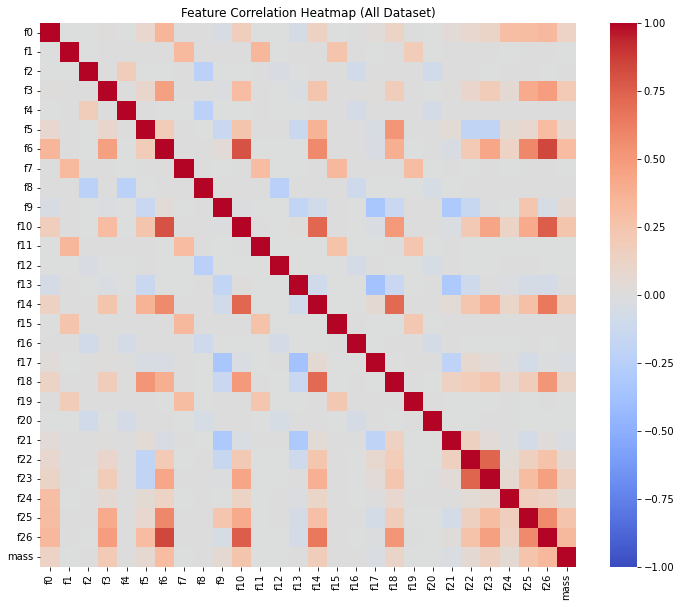

In [20]:
corr_matrix = all_data_train.drop(columns=['# label']).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', vmax=1.0, vmin=-1.0, center=0, annot=False)
plt.title('Feature Correlation Heatmap (All Dataset)')
plt.show()

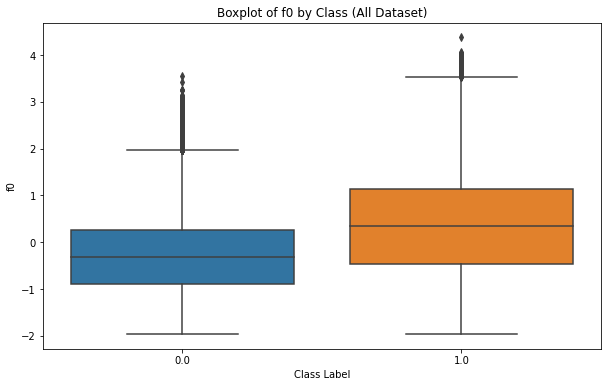

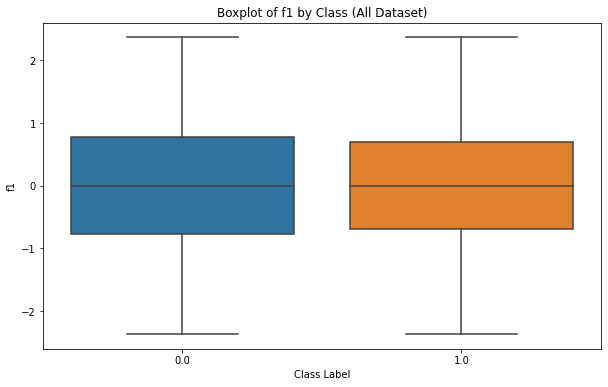

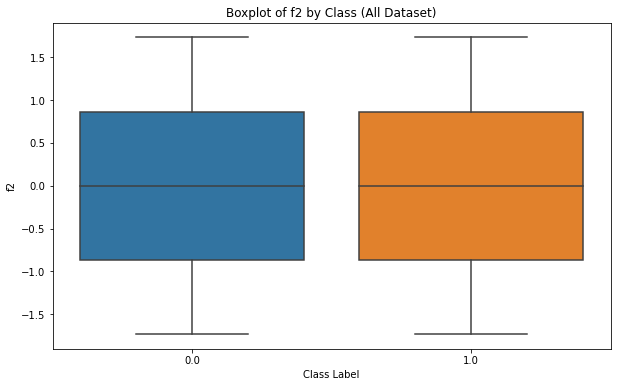

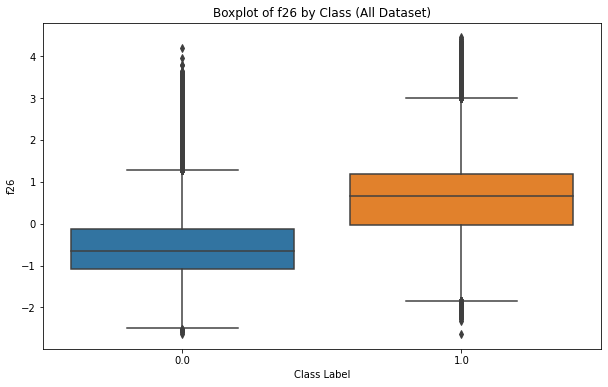

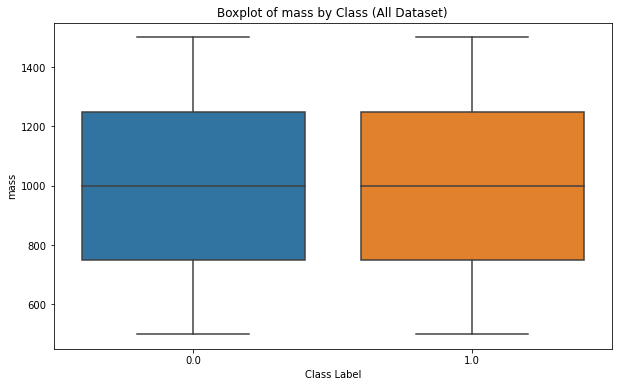

In [21]:
# Boxplots for selected features
for feature in features_to_plot:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=all_data_train, x='# label', y=feature)
    plt.title(f"Boxplot of {feature} by Class (All Dataset)")
    plt.xlabel("Class Label")
    plt.ylabel(feature)
    plt.show()

   Feature  Importance
6       f6    0.195459
26     f26    0.124534
27    mass    0.103332
10     f10    0.091066
14     f14    0.053106
3       f3    0.048531
0       f0    0.046001
25     f25    0.045025
18     f18    0.027477
23     f23    0.023808
22     f22    0.019012
24     f24    0.018643
7       f7    0.018517
11     f11    0.018145
1       f1    0.017821
15     f15    0.017399
19     f19    0.016876
8       f8    0.016603
16     f16    0.016551
12     f12    0.016514
20     f20    0.016504
2       f2    0.016380
4       f4    0.016352
5       f5    0.007163
9       f9    0.002766
13     f13    0.002252
17     f17    0.002139
21     f21    0.002023


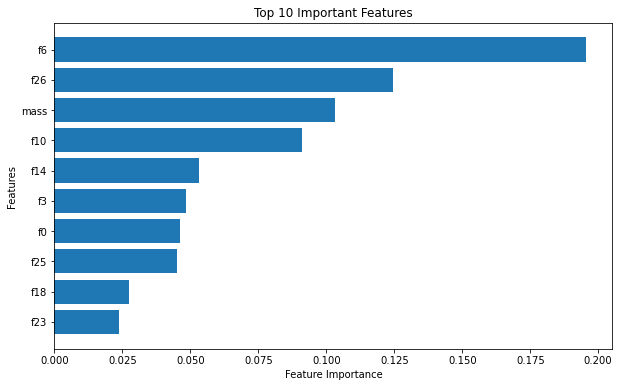

In [22]:
# Feature importance analysis by random forest
# Randomly sample a fraction of the dataset
sampled_data = all_data_train.sample(frac=0.1, random_state=42)
X_sampled = sampled_data.drop(columns=['# label'])
y_sampled = sampled_data['# label']

# Train Random Forest on the sampled dataset
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_sampled, y_sampled)

importance = pd.DataFrame({'Feature': X_sampled.columns, 'Importance': rf.feature_importances_})
importance = importance.sort_values(by='Importance', ascending=False)

print(importance)

# Plot the top 10 features
plt.figure(figsize=(10, 6))
plt.barh(importance['Feature'][:10][::-1], importance['Importance'][:10][::-1]) 
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 10 Important Features')
plt.show()

## Model Analysis
In this section, we start with a simple logistic regression as a baseline model of classification. We then apply more advanced techniques including adaboost and support vector machine algorithms to examine the performance of each model.


=== Logistic Regression for 1000 Dataset ===
Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.90      0.91   1750755
         1.0       0.90      0.92      0.91   1749245

    accuracy                           0.91   3500000
   macro avg       0.91      0.91      0.91   3500000
weighted avg       0.91      0.91      0.91   3500000

AUC Score: 0.9612


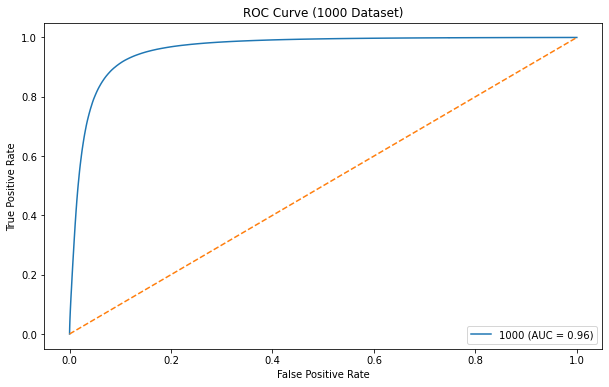


=== Logistic Regression for not1000 Dataset ===
Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.82      0.82   1750755
         1.0       0.82      0.82      0.82   1749245

    accuracy                           0.82   3500000
   macro avg       0.82      0.82      0.82   3500000
weighted avg       0.82      0.82      0.82   3500000

AUC Score: 0.9059


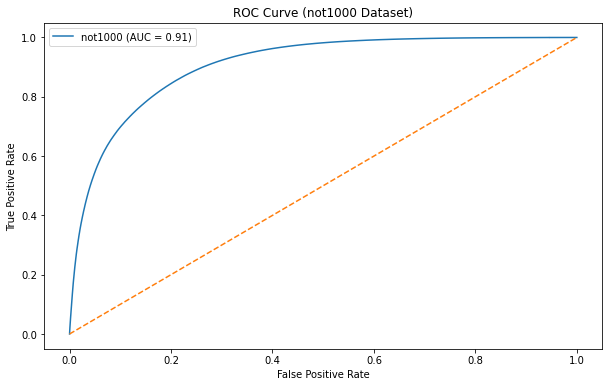


=== Logistic Regression for all Dataset ===
Classification Report:
              precision    recall  f1-score   support

         0.0       0.84      0.84      0.84   1750755
         1.0       0.84      0.84      0.84   1749245

    accuracy                           0.84   3500000
   macro avg       0.84      0.84      0.84   3500000
weighted avg       0.84      0.84      0.84   3500000

AUC Score: 0.9175


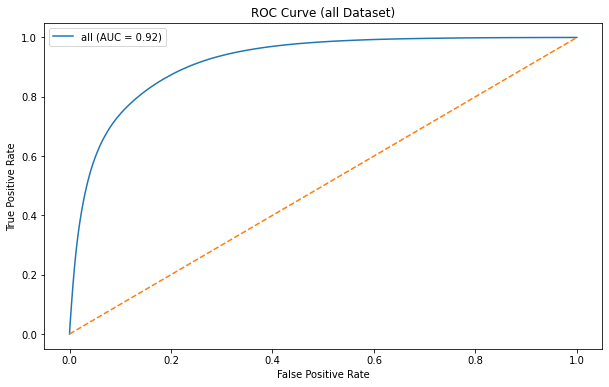

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

datasets = {
    "1000": {
        "train": dataset_1000_train,
        "test": pd.read_csv('/Users/peterzheng/Downloads/hepmass/1000_test.csv.gz', compression='gzip'),
    },
    "not1000": {
        "train": pd.read_csv('/Users/peterzheng/Downloads/hepmass/not1000_train.csv.gz', compression='gzip'),
        "test": pd.read_csv('/Users/peterzheng/Downloads/hepmass/not1000_test.csv.gz', compression='gzip'),
    },
    "all": {
        "train": pd.read_csv('/Users/peterzheng/Downloads/hepmass/all_train.csv.gz', compression='gzip'),
        "test": pd.read_csv('/Users/peterzheng/Downloads/hepmass/all_test.csv.gz', compression='gzip'),
    },
}

results = {}

# Logistic Regression Baseline
for key, data in datasets.items():
    print(f"\n=== Logistic Regression for {key} Dataset ===")
    
    # Split features and labels
    X_train = data["train"].drop(columns=["# label"])
    y_train = data["train"]["# label"]
    X_test = data["test"].drop(columns=["# label"])
    y_test = data["test"]["# label"]

    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train logistic regression
    lr = LogisticRegression(max_iter=1000, random_state=42)
    lr.fit(X_train_scaled, y_train)

    # Predict and evaluate
    y_pred = lr.predict(X_test_scaled)
    y_prob = lr.predict_proba(X_test_scaled)[:, 1]

    # Evaluation metrics
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    auc_score = roc_auc_score(y_test, y_prob)
    print(f"AUC Score: {auc_score:.4f}")

    results[key] = {
        "model": lr,
        "y_test": y_test,
        "y_pred": y_pred,
        "y_prob": y_prob,
        "auc_score": auc_score,
    }

    # Plot ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, label=f"{key} (AUC = {auc_score:.2f})")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve ({key} Dataset)")
    plt.legend()
    plt.show()

## Comments
The invariant mass m is a derived feature, dependent on other quantities like E and $\vec{p}$ through $m^2=E^2-p^2$. By fixing m, the physical system becomes more constrained:
	•	Signal events with m = 1000 have specific kinematic signatures, making them easier to identify.
	•	When m varies, the signal events span a broader range of kinematic possibilities, blending more with background events.

### AdaBoost


=== AdaBoost for 1000 Dataset ===
Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.90      0.91   1750755
         1.0       0.90      0.93      0.91   1749245

    accuracy                           0.91   3500000
   macro avg       0.91      0.91      0.91   3500000
weighted avg       0.91      0.91      0.91   3500000

AUC Score: 0.9678


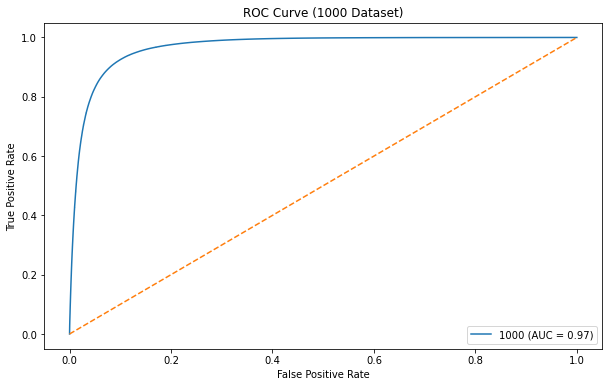


=== AdaBoost for not1000 Dataset ===
Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.86      0.83   1750755
         1.0       0.85      0.78      0.81   1749245

    accuracy                           0.82   3500000
   macro avg       0.82      0.82      0.82   3500000
weighted avg       0.82      0.82      0.82   3500000

AUC Score: 0.9144


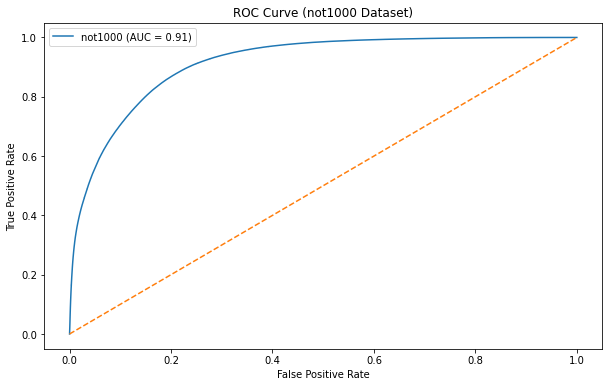


=== AdaBoost for all Dataset ===
Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.87      0.84   1750755
         1.0       0.86      0.80      0.83   1749245

    accuracy                           0.83   3500000
   macro avg       0.84      0.83      0.83   3500000
weighted avg       0.84      0.83      0.83   3500000

AUC Score: 0.9250


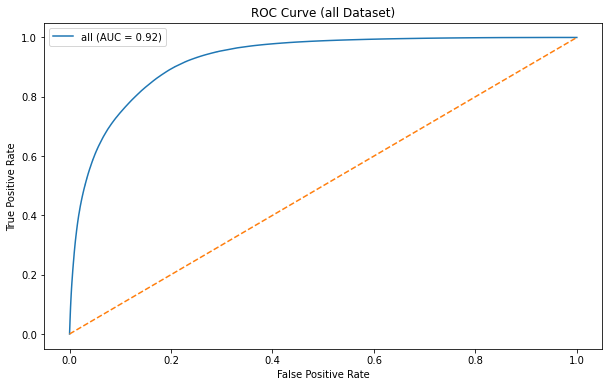

In [34]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

results_adaboost = {}

for key, data in datasets.items():
    print(f"\n=== AdaBoost for {key} Dataset ===")

    X_train = data["train"].drop(columns=["# label"])
    y_train = data["train"]["# label"]
    X_test = data["test"].drop(columns=["# label"])
    y_test = data["test"]["# label"]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    base_clf = DecisionTreeClassifier(max_depth=1)  
    adaboost = AdaBoostClassifier(
        base_estimator=base_clf,
        n_estimators=100,       
        learning_rate=1.0,   
        random_state=42
    )

    # Train AdaBoost
    adaboost.fit(X_train_scaled, y_train)

    y_pred = adaboost.predict(X_test_scaled)
    y_prob = adaboost.predict_proba(X_test_scaled)[:, 1]

    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    auc_score = roc_auc_score(y_test, y_prob)
    print(f"AUC Score: {auc_score:.4f}")

    results_adaboost[key] = {
        "model": adaboost,
        "y_test": y_test,
        "y_pred": y_pred,
        "y_prob": y_prob,
        "auc_score": auc_score,
    }

    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, label=f"{key} (AUC = {auc_score:.2f})")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve ({key} Dataset)")
    plt.legend()
    plt.show()

In [51]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

data = datasets["1000"]

train_subset = data["train"].sample(frac=0.1, random_state=42)
X_train_subset = train_subset.drop(columns=["# label"])
y_train_subset = train_subset["# label"]

scaler = StandardScaler()
X_train_subset_scaled = scaler.fit_transform(X_train_subset)

# Narrowed parameter grid
param_dist = {
    "n_estimators": [10, 50, 100],
    "learning_rate": [0.1, 0.5, 1.0],
    "base_estimator__max_depth": [1, 2,3]
}

# RandomizedSearchCV with fewer iterations and folds
random_search = RandomizedSearchCV(
    estimator=adaboost,
    param_distributions=param_dist,
    n_iter=5,  # Reduced iterations
    scoring="roc_auc",
    cv=3,      # Reduced CV folds
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train_subset_scaled, y_train_subset)

# Output results
print("Best Parameters:", random_search.best_params_)
print("Best AUC Score:", random_search.best_score_)

Best Parameters: {'n_estimators': 50, 'learning_rate': 0.5, 'base_estimator__max_depth': 2}
Best AUC Score: 0.9687320488490291


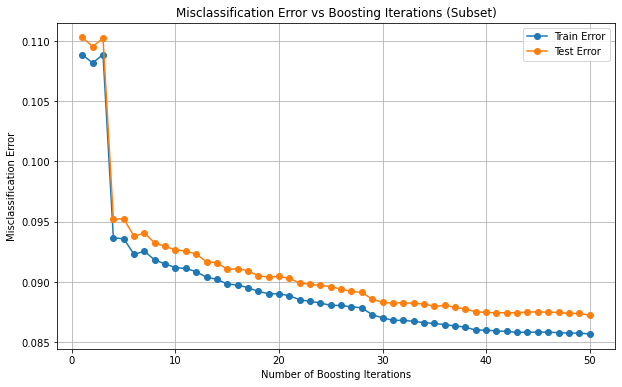

In [57]:
# Train final AdaBoost with best parameters
test_subset = data["test"].sample(frac=0.1, random_state=42)
X_test_subset = test_subset.drop(columns=["# label"])
y_test_subset = test_subset["# label"]

scaler = StandardScaler()
X_train_subset_scaled = scaler.fit_transform(X_train_subset)
X_test_subset_scaled = scaler.transform(X_test_subset)


best_params = random_search.best_params_

# Train AdaBoost
best_adaboost = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=best_params["base_estimator__max_depth"]),
    n_estimators=best_params["n_estimators"],
    learning_rate=best_params["learning_rate"],
    random_state=42
)

best_adaboost.fit(X_train_subset_scaled, y_train_subset)

def staged_score(model, X, y):
    staged_scores = []
    for y_pred in model.staged_predict(X):
        score = np.mean(y_pred == y)
        staged_scores.append(score)
    return staged_scores

train_scores = staged_score(best_adaboost, X_train_subset_scaled, y_train_subset)
test_scores = staged_score(best_adaboost, X_test_subset_scaled, y_test_subset)

# Convert scores to misclassification errors
train_errors = [1 - score for score in train_scores]
test_errors = [1 - score for score in test_scores]

# Plot the misclassification errors
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_errors) + 1), train_errors, label="Train Error", marker="o")
plt.plot(range(1, len(test_errors) + 1), test_errors, label="Test Error", marker="o")
plt.xlabel("Number of Boosting Iterations")
plt.ylabel("Misclassification Error")
plt.title("Misclassification Error vs Boosting Iterations (Subset)")
plt.legend()
plt.grid(True)
plt.show()

The plot shows that both train and test misclassification errors decrease rapidly in the initial boosting iterations and stabilize around 30-50 iterations. The test error plateaus slightly above the train error, indicating minimal overfitting and good generalization. The small gap between train and test errors suggests the AdaBoost model is robust, with sufficient complexity to classify the data effectively. Beyond 50 iterations, additional boosting provides diminishing returns, making this range optimal for balancing performance and computational efficiency.

### Confusion matrix analysis

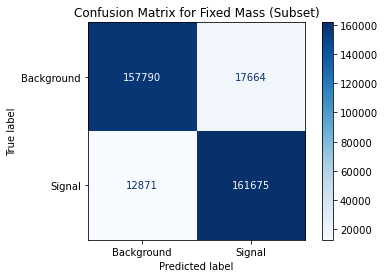

In [60]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.metrics import classification_report

# Predict using the trained AdaBoost model
y_pred_subset = best_adaboost.predict(X_test_subset_scaled)

# Compute confusion matrix
cm = confusion_matrix(y_test_subset, y_pred_subset)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Background", "Signal"])

# Plot confusion matrix
disp.plot(cmap="Blues")
plt.title("Confusion Matrix for Fixed Mass (Subset)")
plt.show()

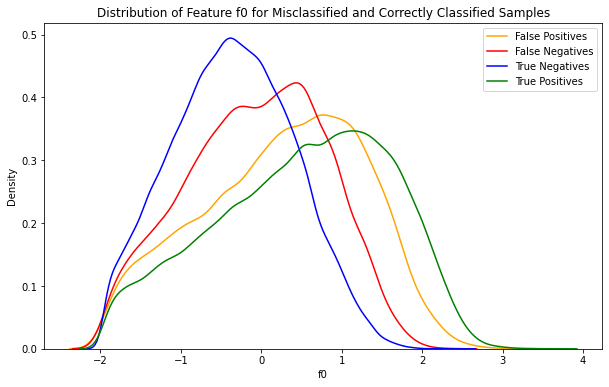

In [62]:
# Compare feature distributions for FP and FN
false_positives = (y_test_subset == 0) & (y_pred_subset == 1)  # FP
false_negatives = (y_test_subset == 1) & (y_pred_subset == 0)  # FN
correct_negatives = (y_test_subset == 0) & (y_pred_subset == 0)  # TN
correct_positives = (y_test_subset == 1) & (y_pred_subset == 1)  # TP

# Combine into DataFrame for analysis
analysis_df = pd.DataFrame(X_test_subset)
analysis_df["True Label"] = y_test_subset
analysis_df["Predicted Label"] = y_pred_subset


plt.figure(figsize=(10, 6))
sns.kdeplot(analysis_df.loc[false_positives, "f0"], label="False Positives", color="orange")
sns.kdeplot(analysis_df.loc[false_negatives, "f0"], label="False Negatives", color="red")
sns.kdeplot(analysis_df.loc[correct_negatives, "f0"], label="True Negatives", color="blue")
sns.kdeplot(analysis_df.loc[correct_positives, "f0"], label="True Positives", color="green")
plt.title("Distribution of Feature f0 for Misclassified and Correctly Classified Samples")
plt.xlabel("f0")
plt.ylabel("Density")
plt.legend()
plt.show()

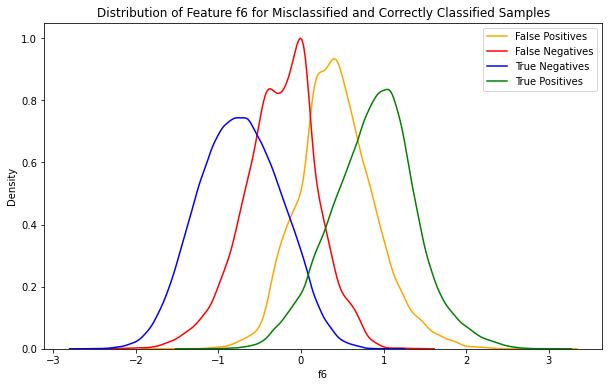

In [65]:
plt.figure(figsize=(10, 6))
sns.kdeplot(analysis_df.loc[false_positives, "f6"], label="False Positives", color="orange")
sns.kdeplot(analysis_df.loc[false_negatives, "f6"], label="False Negatives", color="red")
sns.kdeplot(analysis_df.loc[correct_negatives, "f6"], label="True Negatives", color="blue")
sns.kdeplot(analysis_df.loc[correct_positives, "f6"], label="True Positives", color="green")
plt.title("Distribution of Feature f6 for Misclassified and Correctly Classified Samples")
plt.xlabel("f6")
plt.ylabel("Density")
plt.legend()
plt.show()

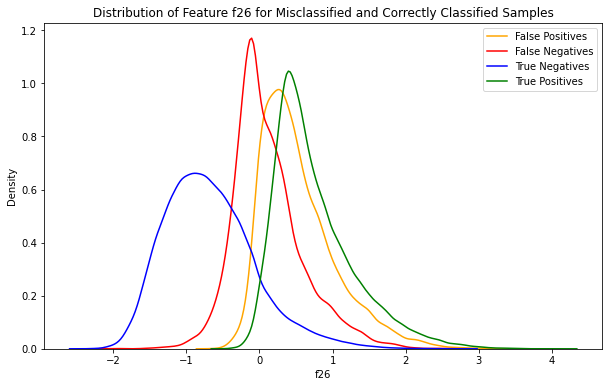

In [66]:
plt.figure(figsize=(10, 6))
sns.kdeplot(analysis_df.loc[false_positives, "f26"], label="False Positives", color="orange")
sns.kdeplot(analysis_df.loc[false_negatives, "f26"], label="False Negatives", color="red")
sns.kdeplot(analysis_df.loc[correct_negatives, "f26"], label="True Negatives", color="blue")
sns.kdeplot(analysis_df.loc[correct_positives, "f26"], label="True Positives", color="green")
plt.title("Distribution of Feature f26 for Misclassified and Correctly Classified Samples")
plt.xlabel("f26")
plt.ylabel("Density")
plt.legend()
plt.show()

### Discussion/Conclusion

The primary goal of this project was to classify particle collision events from the HEPMASS dataset to identify new physics signals. We aimed to distinguish between signal-producing collisions and background events, focusing on scenarios with fixed mass (1000) to simplify the complexity of feature space and ensure more precise classification.

After performing exploratory data analysis to understand the dataset, we focused on the 1000 subset with fixed mass for both training and testing. Several machine learning models, including Logistic Regression, k-NN, and AdaBoost, were evaluated to establish a baseline and refine performance. AdaBoost was selected for its strong performance and ability to focus on hard-to-classify samples, and hyperparameter optimization was performed using RandomizedSearchCV.

The AdaBoost classifier achieved the best performance, with an AUC of 0.96 on the test subset. The model demonstrated robust generalization, as seen in the small gap between training and test misclassification errors. From the confusion matrix, we observed high precision (90%) and recall (93%), indicating the model effectively distinguished between signal and background. Despite the strong performance, the model struggled with misclassifying some samples, particularly in regions where signal and background features overlapped. Additionally, the inclusion of mass as a feature in non-fixed datasets added complexity that was not fully addressed within this project. Due to computational constraints, the analysis was performed on a subset of the data, which may have limited the model’s ability to capture subtle patterns in the full dataset.

In conclusion, this project successfully applied machine learning techniques to classify particle collision events, achieving strong performance with AdaBoost on the fixed-mass subset. The results lay a foundation for extending this analysis to more complex datasets and advancing the use of ML in particle physics.